## 01-BU
INFOSYS722 - Iteration 4 - BDAS
Author: S. Schmidt<br>Date: 10/05/2024<br>
Desc: Primary question: Is the date the UN set of the year 2030 achievable for Goal 2, Zero world hunger?<br><br>
This Spark program reads in the Global Health Index values collected for each country and calculates a Mean value<br>
for each collected year. <br>This mean value is then used to predict the date when "Zero Hunger" will be reached and in turn, provide insight into when Zero Hunger will be reached.


## # 02-DU
Load up libraries and retrieve datasource


In [1]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
import sys

#from pyspark.sql.SQLContext import sqlContext
spark = SparkSession.builder.appName('predict_un_ghi_target_date').getOrCreate()
#from pyspark.ml.regression import LinearRegression

#from pyspark.pandas import pypandas
import pandas as pd
import numpy as np

# Import VectorAssembler and Vectors
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, StringIndexer

from sklearn.linear_model import LinearRegression


24/05/14 15:13:30 WARN Utils: Your hostname, dev2 resolves to a loopback address: 127.0.1.1; using 192.168.1.217 instead (on interface eth0)
24/05/14 15:13:30 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/14 15:13:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
platform = sys.platform
recur_limit = sys.getrecursionlimit()
print("The recursion limit for %s platform is %s" % (platform, recur_limit))
sys.setrecursionlimit(1000)
new_recur_limit = sys.getrecursionlimit()
print("The new recursion limit for %s platform is %s" % (platform, new_recur_limit))

# Use Spark to read in the Ecommerce Customers csv file. You can infer csv schemas. 
data = spark.read.csv("global-hunger-index.csv",inferSchema=True,header=True)

The recursion limit for linux platform is 3000
The new recursion limit for linux platform is 1000


In [3]:
# Print the schema of the DataFrame. You can see potential features as well as the predictor.
data.printSchema()

root
 |-- Entity: string (nullable = true)
 |-- Code: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Global Hunger Index (2021): double (nullable = true)
 |-- 411773-annotations: string (nullable = true)



## # 03-DP


In [4]:
# Let's focus on one row to make it easier to read.
data.head(10)

[Row(Entity='Afghanistan', Code='AFG', Year=2000, Global Hunger Index (2021)=50.9, 411773-annotations=None),
 Row(Entity='Afghanistan', Code='AFG', Year=2006, Global Hunger Index (2021)=42.7, 411773-annotations=None),
 Row(Entity='Afghanistan', Code='AFG', Year=2012, Global Hunger Index (2021)=34.3, 411773-annotations=None),
 Row(Entity='Afghanistan', Code='AFG', Year=2021, Global Hunger Index (2021)=28.3, 411773-annotations=None),
 Row(Entity='Albania', Code='ALB', Year=2000, Global Hunger Index (2021)=20.7, 411773-annotations=None),
 Row(Entity='Albania', Code='ALB', Year=2006, Global Hunger Index (2021)=15.9, 411773-annotations=None),
 Row(Entity='Albania', Code='ALB', Year=2012, Global Hunger Index (2021)=8.8, 411773-annotations=None),
 Row(Entity='Albania', Code='ALB', Year=2021, Global Hunger Index (2021)=6.2, 411773-annotations=None),
 Row(Entity='Algeria', Code='DZA', Year=2000, Global Hunger Index (2021)=14.5, 411773-annotations=None),
 Row(Entity='Algeria', Code='DZA', Year=2

In [5]:
# A simple for loop allows us to make it even clearer. 
for item in data.head(10):
    print(item)

Row(Entity='Afghanistan', Code='AFG', Year=2000, Global Hunger Index (2021)=50.9, 411773-annotations=None)
Row(Entity='Afghanistan', Code='AFG', Year=2006, Global Hunger Index (2021)=42.7, 411773-annotations=None)
Row(Entity='Afghanistan', Code='AFG', Year=2012, Global Hunger Index (2021)=34.3, 411773-annotations=None)
Row(Entity='Afghanistan', Code='AFG', Year=2021, Global Hunger Index (2021)=28.3, 411773-annotations=None)
Row(Entity='Albania', Code='ALB', Year=2000, Global Hunger Index (2021)=20.7, 411773-annotations=None)
Row(Entity='Albania', Code='ALB', Year=2006, Global Hunger Index (2021)=15.9, 411773-annotations=None)
Row(Entity='Albania', Code='ALB', Year=2012, Global Hunger Index (2021)=8.8, 411773-annotations=None)
Row(Entity='Albania', Code='ALB', Year=2021, Global Hunger Index (2021)=6.2, 411773-annotations=None)
Row(Entity='Algeria', Code='DZA', Year=2000, Global Hunger Index (2021)=14.5, 411773-annotations=None)
Row(Entity='Algeria', Code='DZA', Year=2006, Global Hunger 

## 04-DT
Data Transform - Process data source to produce Mean values for each year.

In [6]:
#data.sort(['Year']).groupBy("Year").mean("Global Hunger Index (2021)").show()
df_raw = data.groupBy("Year").mean("Global Hunger Index (2021)")
df_raw = df_raw.withColumnRenamed("avg(Global Hunger Index (2021))", "MeanGHIraw")
#print(df_raw)
df_raw
for item in df_raw:
    print(item)
#df = df_raw.withColumn('MeanGHI', round(df_raw.MeanGHIraw , 4))
#spark.registerDataFrameAsTable(df_raw, "df_Raw_Table")
#df = spark.sql("SELECT Year, `Global Hunger Index (2021)` as MeanGHIraw from df_Raw_Table")


Column<'Year'>
Column<'MeanGHIraw'>


In [7]:
df_raw.summary().show()
df_raw.createOrReplaceTempView("df_Raw_Table")
#df = spark.sql("SELECT Year, `Global Hunger Index (2021)` as MeanGHIraw from df_Raw_Table")
df = spark.sql("select Year, round(MeanGHIraw, 4) as MeanGHI from df_Raw_Table")
df
df.createOrReplaceTempView("df_Table")
#df.summary().show()
#df.describe()


+-------+-----------------+------------------+
|summary|             Year|        MeanGHIraw|
+-------+-----------------+------------------+
|  count|                4|                 4|
|   mean|          2009.75| 19.94550241620261|
| stddev|8.958236433584458|3.5256811798596144|
|    min|             2000|         16.790625|
|    25%|             2000|         16.790625|
|    50%|             2006| 17.50862068965517|
|    75%|             2012| 21.04347826086957|
|    max|             2021| 24.43928571428571|
+-------+-----------------+------------------+



## 05-DMM
Data Transform - Process data source to produce Mean values for each year.

+----+-------+
|Year|MeanGHI|
+----+-------+
|2000|24.4393|
|2006|21.0435|
|2012|17.5086|
|2021|16.7906|
+----+-------+



<Axes: xlabel='Year'>

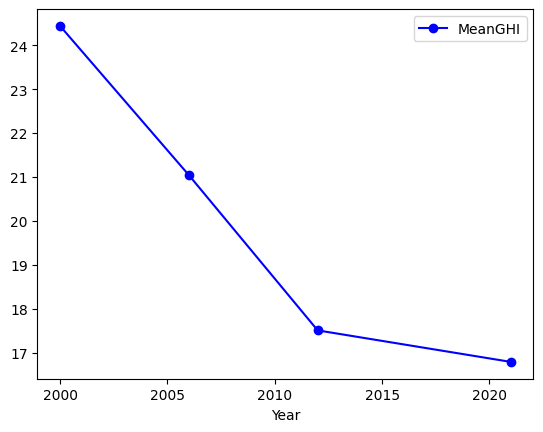

In [8]:
## Plot Initial MeanGHI data
df1=spark.sql("Select * from df_Table order by Year")
df1.show()
pdf1=df1.toPandas()
pdf1.plot(kind='line', x='Year',y='MeanGHI', linestyle="solid", marker="o", color="blue")


In [9]:

df2 = spark.sql("Select DATE(concat(Year, '-01-01')) as Year, MeanGHI from df_Table order by Year limit 3")
df2.show()
df2.describe().show()
df2.printSchema()
#pdf2=df2.toPandas()
#print(pdf2)
#indexer = StringIndexer(inputCol="Year", outputCol="YearIdx")
indexer = VectorAssembler(
    inputCols=["Year"],
    outputCol="YearIdx")

indexer2 = indexer.transform(df1)
#indexed = indexer2.fit(df2)
indexer2.printSchema()
indexer2.show()

x3 = indexer2["Year"]
#x3 = x3.reshape(-1,1)
y3 = indexer2["MeanGHI"]
print(x3)
print(y3)

#lr = LinearRegression(featuresCol="Year", labelCol="MeanGHI")model = lr.fit(indexer2)

r1 = LinearRegression()
r1.fit(x3,y3)

print(r1.intercept_,r1.coef_)
print(r1.predict([[2040],[2045],[2050],[2055],[2060],[2065]]))

#lr = LinearRegression(featuresCol='YearIdx', labelCol='MeanGHI', predictionCol='prediction')
#lrModel = lr.fit(indexer2)
#predictions = lrModel.transform(indexer2)

#print("Coefficients: {} Intercept: {}".format(lrModel.coefficients,lrModel.intercept))

#test_results = lrModel.evaluate(indexer2)
#test_results.residuals.show()

#predictions.show()
#predictions.head(6)


+----------+-------+
|      Year|MeanGHI|
+----------+-------+
|2000-01-01|24.4393|
|2006-01-01|21.0435|
|2012-01-01|17.5086|
+----------+-------+

+-------+------------------+
|summary|           MeanGHI|
+-------+------------------+
|  count|                 3|
|   mean|20.997133333333334|
| stddev|3.4655826383644817|
|    min|           17.5086|
|    max|           24.4393|
+-------+------------------+

root
 |-- Year: date (nullable = true)
 |-- MeanGHI: double (nullable = true)

root
 |-- Year: integer (nullable = true)
 |-- MeanGHI: double (nullable = true)
 |-- YearIdx: vector (nullable = true)

+----+-------+--------+
|Year|MeanGHI| YearIdx|
+----+-------+--------+
|2000|24.4393|[2000.0]|
|2006|21.0435|[2006.0]|
|2012|17.5086|[2012.0]|
|2021|16.7906|[2021.0]|
+----+-------+--------+

Column<'Year'>
Column<'MeanGHI'>


RecursionError: maximum recursion depth exceeded in comparison

## 05-DMM
Data Transform - Process data source to produce Mean values for each year.

In [ ]:
# The input columns are the feature column names, and the output column is what you'd like the new column to be named. 
assembler = VectorAssembler(
    inputCols=["Year", "Global Hunger Index (2021)"],
    outputCol="MeanGHI")

In [ ]:
# Now that we've created the assembler variable, let's actually transform the data.
output = assembler.transform(data)

In [ ]:
# Using print schema, you see that the features output column has been added. 
output.printSchema()

# You can see that the features column is a dense vector that combines the various features as expected.
output.head(1)

In [ ]:
# Let's select two columns (the feature and predictor).
# This is now in the appropriate format to be processed by Spark.
final_data = output.select("features",'Yearly Amount Spent')
final_data.show()

In [ ]:
# Let's do a randomised 70/30 split. 
# Remember, you can use other splits depending on how easy/difficult it is to train your model.
train_data,test_data = final_data.randomSplit([0.7,0.3])

In [ ]:
# Let's see our training data.
train_data.describe().show()

# And our testing data.
test_data.describe().show()

Now we can create a Linear Regression Model object. Because the feature column is named 'features', we don't have to worry about it. However, as the labelCol isn't the default name, we have to specify it's name (Yearly Amount Spent).

In [ ]:
lr = LinearRegression(labelCol='Yearly Amount Spent')

In [ ]:
# Fit the model to the data.
lrModel = lr.fit(train_data)

In [ ]:
# Print the coefficients and intercept for linear regression.
print("Coefficients: {} Intercept: {}".format(lrModel.coefficients,lrModel.intercept))

In [ ]:
# Let's evaluate the model against the test data.
test_results = lrModel.evaluate(test_data)

In [ ]:
# Interesting results! This shows the difference between the predicted value and the test data.
test_results.residuals.show()

# Let's get some evaluation metrics (as discussed in the previous linear regression notebook).
print("RSME: {}".format(test_results.rootMeanSquaredError))

In [ ]:
# We can also get the R2 value. 
print("R2: {}".format(test_results.r2))

Looking at RMSE and R2, we can see that the model is quite accurate. The RMSE shows that, on average, there's only a \\$10 discrepancy between the actual and predicted results. Comparing this to the table below, the average amount spent (\\$499) and standard deviation (\\$79), a \\$10 error is surprisingly good. 

The R2 also shows that the model accounts for 98% of the variance in the data. 

In [ ]:
final_data.describe().show()

## But what if we didn't have the predictor data?

This isn't really relevant to your assignment, but useful in a real-world scenario. What if you have all of these features but no predictor data? How do you actually use the model you've created? Check out the example below.

In [ ]:
# Let's just select the features column (removing the label column).
unlabeled_data = test_data.select('features')
unlabeled_data.show()

In [ ]:
# Now we can transform the unlabeled data.
predictions = lrModel.transform(unlabeled_data)

In [ ]:
# It worked! Feeding the unlabeled data features into the model results in a prediction, 
# which is the amount someone with those features is likely to spend in a year.
predictions.show()
predictions.head(1)